In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from PIL import Image
import os
import matplotlib.pyplot as plt
import random

%matplotlib inline 

/home/yaroslav_opanasenko99/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


In [3]:
def label_img(name, folder):
    if folder!= 'Vlad':
        word_label = list(name)[0]
    else:
        word_label = list(name)[-5]
    return word_label

In [4]:
os.getcwd()

'/home/yaroslav_opanasenko99/hackaton'

In [7]:
IMG_SIZE = 64

DIR = ['data/pictures/data_rus', 'data/pictures/data_yar', 'data/pictures/data_max', 'data/pictures/data_vlad']

def load_training_data():
    k=0
    train_data = []
    labels = []
    for folder in DIR:
        for img in os.listdir(str(folder)):
            label = label_img(img, folder)
            path = os.path.join(str(folder), img)
            img = Image.open(path)
            img = img.convert('L')
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            k+=1
#             img.save('pictures/pic'+str(k)+'.jpg')
            
            train_data.append(np.array(img))
            labels.append(label)
            # Basic Data Augmentation - Horizontal Flipping and Vertical Flipping
            flip_img = Image.open(path)
            flip_img = flip_img.convert('L')
            flip_img = flip_img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
            flip_img1 = np.array(flip_img)

            flip_img = np.flip(flip_img1,axis=0)
            train_data.append(flip_img)
            labels.append(label)

    train_data = np.array(train_data)
    return train_data, labels

data, labels = load_training_data()

In [8]:
def augment_images(data, labels, copies = 1, rotation=True, shear=True, shift=True, zoom=True):
    augmented_data = []
    augmented_labels = []
    
    for i in range (0, np.shape(labels)[0]):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        
        for j in range(1, copies):            
            img = data[i]
            lbl = labels[i]
                        
            if (rotation):
                img = tf.contrib.keras.preprocessing.image.random_rotation(img, 15, row_axis=0, col_axis=1, channel_axis=2)
            if (shear):
                img = tf.contrib.keras.preprocessing.image.random_shear(img, 0.1, row_axis=0, col_axis=1, channel_axis=2)
            if (shift):
                img = tf.contrib.keras.preprocessing.image.random_shift(img, 0.15, 0.15, row_axis=0, col_axis=1, channel_axis=2)
            if (zoom):
                img = tf.contrib.keras.preprocessing.image.random_zoom(img, (0.9, 1.1), row_axis=0, col_axis=1, channel_axis=2)
            
            augmented_data.append(img)
            augmented_labels.append(lbl)
    
    return np.array(augmented_data), np.array(augmented_labels)

In [9]:
X = data.reshape(-1, 64, 64, 1).astype(np.float32)
X /= 255.0

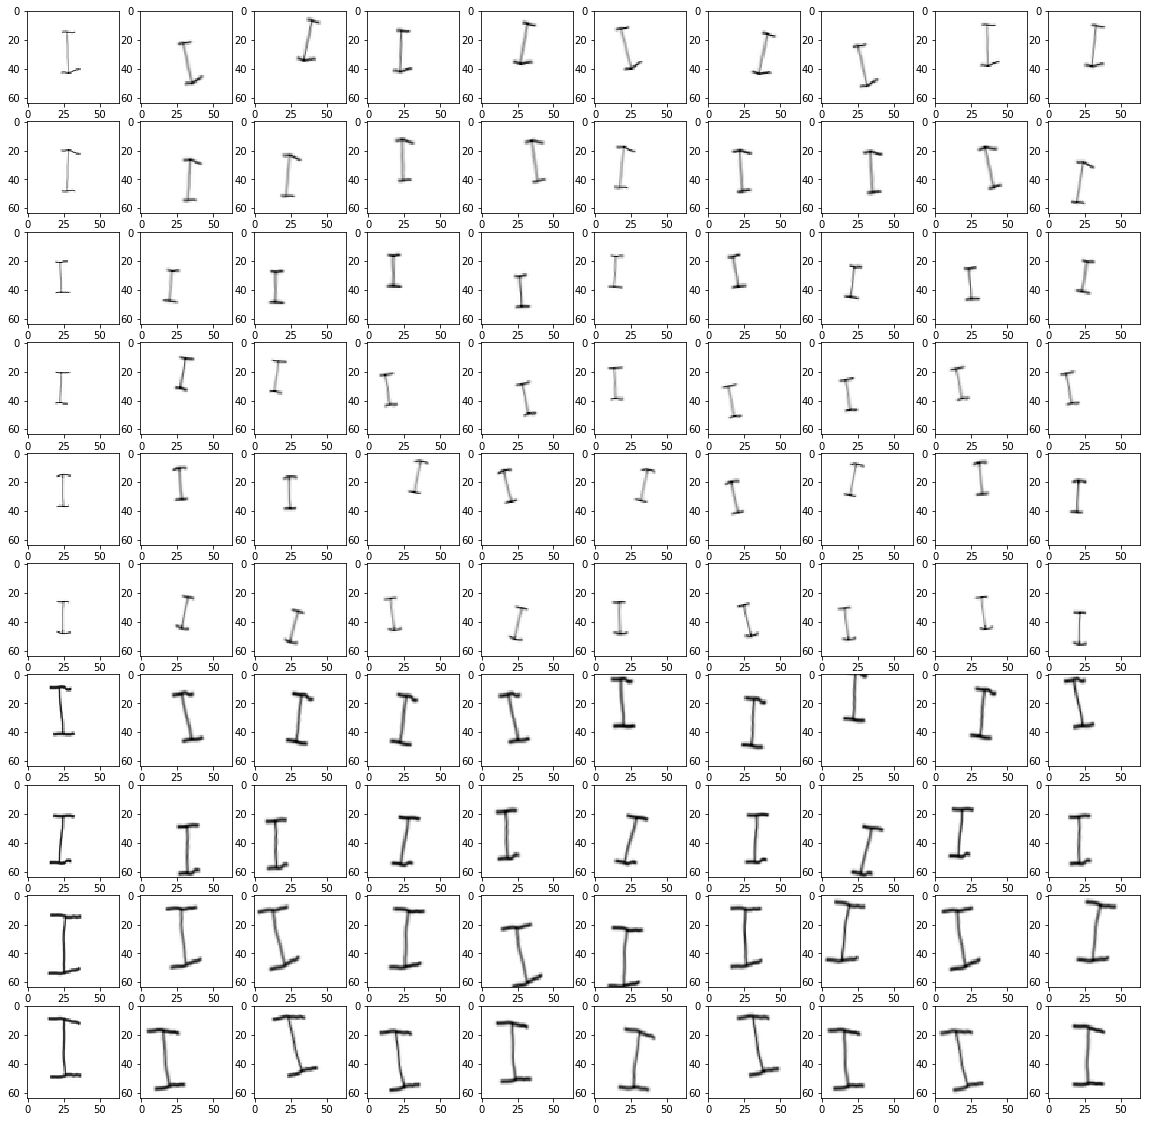

In [10]:
x = X[:10]
y = labels[:10]
x, y = augment_images(x, y, copies=10,zoom=False)

plt.figure(figsize=(20,20))
for i in range(len(x)):
    plt.subplot(10,10,1+i)
    plt.imshow(x[i].reshape(64,64), cmap='gist_gray')
    


In [11]:
data_, labels_ = augment_images(X, labels, copies=10,zoom=False)
data_.shape, labels_.shape

((8040, 64, 64, 1), (8040,))

In [12]:
labels_ = pd.get_dummies(labels_).values

In [13]:
train_data,test_data,train_labels, test_labels = train_test_split(data_,labels_,test_size=0.2, random_state = 0)

In [14]:
del X,y
from tensorflow.contrib.layers import dropout

In [15]:
check = train_data[0]

### Modelling

In [27]:
activation_function = ['leaky_relu','relu','sigmoid','tanh']
optimizers = ['Adam','momentum','adadelta','nesterov']

In [28]:
tf.reset_default_graph()

In [29]:
learning_rate = 0.01
n_epoch = 100
batch_size = 64
n_batches = int(np.ceil((train_data.shape[0]/batch_size)))
height, width, channels = train_data.shape[1:] 
num_classes = 8

In [30]:
X = tf.placeholder(dtype = tf.float32, shape = [None, height, width, channels])
y = tf.placeholder('float', shape = [None, num_classes])

In [31]:
def filters_init(shape,channels,number,l):
    filter_ = tf.get_variable('f'+str(l),shape=(shape, shape, channels, number), initializer=tf.contrib.layers.xavier_initializer())
    return filter_

def bias_init(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W, b, strides=1):
    # Conv2D, bias, batch_norm, relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    x = tf.layers.batch_normalization(x, axis=-1,momentum=0.99,epsilon=0.001,center=True,
                                     scale=True,beta_initializer=tf.zeros_initializer(),
                                      gamma_initializer=tf.ones_initializer(),
                                      moving_mean_initializer=tf.zeros_initializer(),
                                      moving_variance_initializer=tf.ones_initializer(),
                                        training=False,
                                        trainable=True,
                                        renorm=False,
                                        renorm_momentum=0.99,
    )
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [32]:
weights = {
    'wc1': filters_init(5, channels,32,1), 
    'wc2': filters_init(3, 32, 64,2), 
    'wc3': filters_init(3, 64, 128,3), 
    #'wc4': filters_init(3, 128, 256), 

    'wd1': tf.get_variable('W3', shape=(8*8*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,num_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}

biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer()),
}

In [33]:
def conv_net(x, weights, biases):  

    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)

    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [34]:
pred = conv_net(X, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
#    if optim == 'Adam':
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)        
#    elif optim == 'RMSProp':  
#        tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

In [35]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [36]:
init = tf.global_variables_initializer()

In [41]:
X 

<tf.Tensor 'Placeholder:0' shape=(?, 64, 64, 1) dtype=float32>

In [44]:
batch_x.shape

(64, 64, 64, 1)

In [45]:
y

<tf.Tensor 'Placeholder_1:0' shape=(?, 8) dtype=float32>

In [37]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for i in range(n_epoch):
        for batch in range(n_batches):
            print(batch)
            batch_x = train_data[batch*batch_size:min((batch+1)*batch_size,len(train_data))]
            batch_y = train_labels[batch*batch_size:min((batch+1)*batch_size,len(train_labels))]    
            opt = sess.run(optimizer, feed_dict={X: batch_x,y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={X: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_data,y : test_labels})
        train_loss.append(loss)
        test_loss.append(valid_loss)   
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))


0


ValueError: Cannot feed value of shape (64, 9) for Tensor 'Placeholder_1:0', which has shape '(?, 8)'